# Определение возраста покупателей

## Описание проекта

    Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
        Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
        Контролировать добросовестность кассиров при продаже алкоголя.

    Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 
    
    Исходные данные: набор фотографий людей с указанием возраста.

## План по выполнению проекта
    
    1) Провести исследовательский анализ набора фотографий.
    2) Подготовить данные к обучению.
    3) Обучить нейронную сеть и рассчитать её качество.

## Исследовательский анализ данных

In [71]:
# импортируем все необходимые библиотеки в первой ячейке
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

from PIL import Image
import random
import os

In [72]:
# общую часть пути к базе фотографий пропишем в переменную
path = '/datasets/faces/'

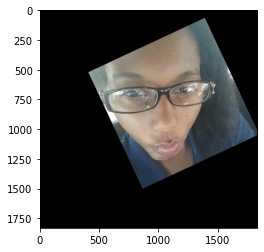

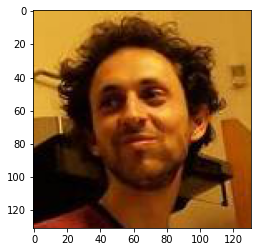

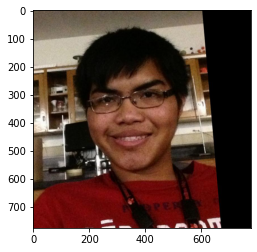

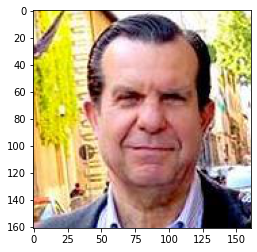

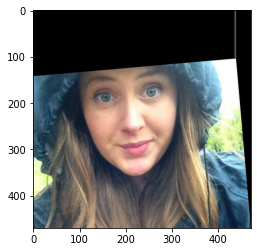

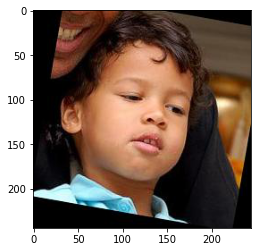

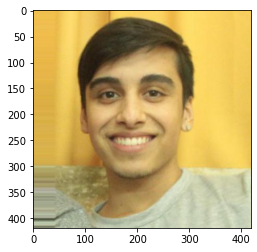

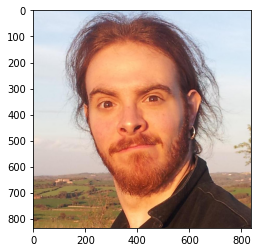

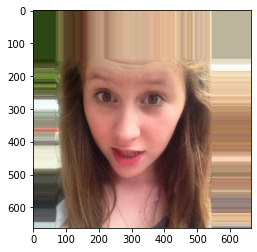

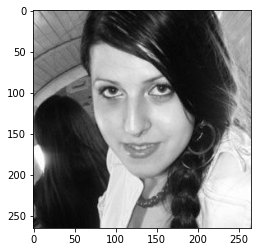

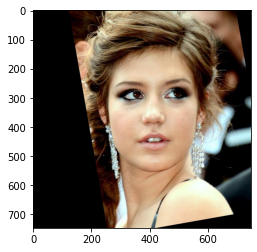

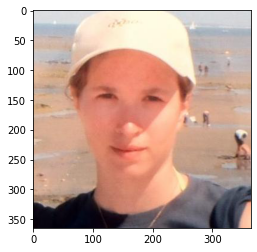

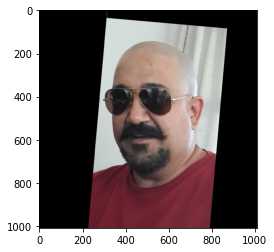

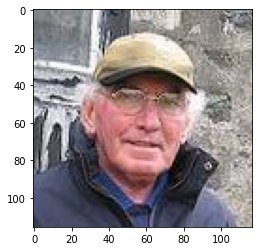

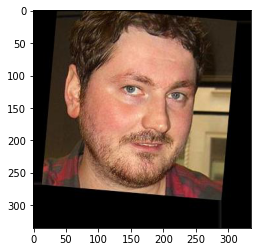

In [73]:
#посмотрим на фотографии, с которыми будет работать модель
photos = os.listdir(path + '/final_files/')
for i in random.sample(photos, k=15):

    image = Image.open(path + '/final_files/' + i)
    plt.imshow(np.array(image))
    plt.show()

    В результате неоднократного выполнения кода на запрос 15 случайных фотографий выявлено, что в базе содержатся:
    
    1) фото различного размера и качества
    2) черно-белые и цветные фото
    3) фотографии, повернутые на различное число градусов в разные стороны
    4) на фотографиях присутствуют различные "артефакты" (другие лица, накладные усы и т.п.)

In [74]:
# загрузим датасет
df_labels = pd.read_csv(path + 'labels.csv')
    
df_labels.info()
display(df_labels.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В выборке 7591 фото. Этого вполне достаточно для обучения модели

In [75]:
# проверим датасет на дубликаты
print("Дубликатов выявлено:", df_labels.duplicated().sum())

Дубликатов выявлено: 0


In [76]:
# проанализируем основные статистики датасета
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


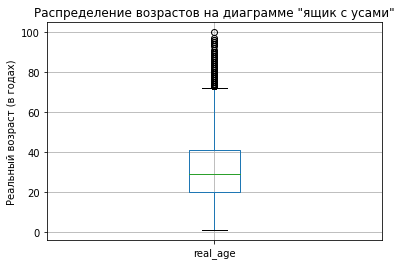

In [77]:
#построим boxplot 
df_labels.boxplot(column='real_age')
plt.ylabel("Реальный возраст (в годах)")
plt.title('Распределение возрастов на диаграмме "ящик с усами"')
plt.show()

Среднее значение - 31 год. Медиана - 29 год. Это активная часть покупателей, но нельзя упускать из вида 75 перцентиль (41 год) - тут может быть наибольшая выручка (ввиду покупательской способности)

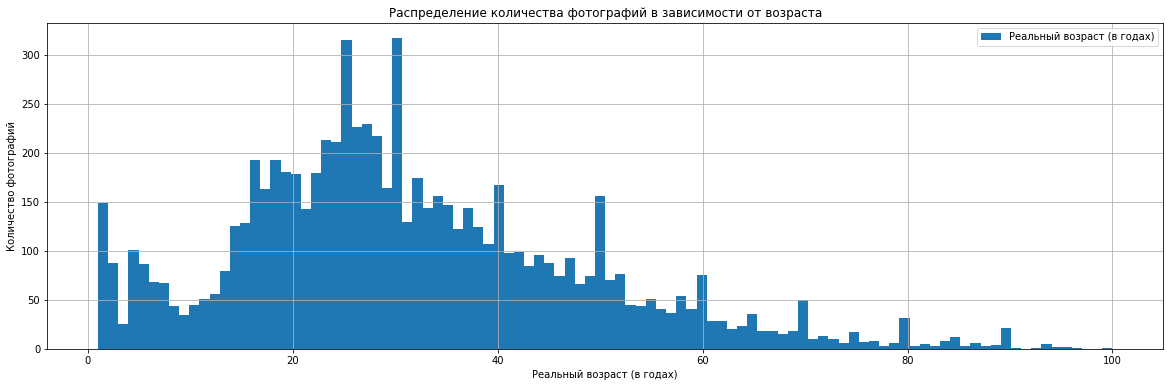

In [78]:
# построим гистограмму распределения возрастов в базе фотографий
df_labels.plot(kind='hist', y='real_age', bins=100, label='Реальный возраст (в годах)', grid=True, figsize=(20,6), 
               title='Распределение количества фотографий в зависимости от возраста')
#подпишем оси на графике
plt.xlabel("Реальный возраст (в годах)")
plt.ylabel("Количество фотографий")
plt.show()

По результатам исследовательского анализа данных видно, что основная масса фото в выборке относится к людям до 40 лет (смещение влево). Для понимания, насколько выборка соответствует реальному региону использования модели необходимо знать распределение (половозрастную структуру) в конкретном регионе или стране. В целом, распределение близко к нормальному. Здесь следует сделать поправку на стоп-фактор по возрасту продажи алкоголя в конкретной стране (расширить границы диапазона для модели, когда кассир должен проверять паспорт, до +7-10 лет к предсказаниям модели)

## Обучение модели

In [ ]:
# функция для загрузки данных
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

# функция для загрузки данных
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

# функция для создания модель
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model

# функция для обучения модели
def train_model(model, train_data, test_data, batch_size=None, epochs=11,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

In [ ]:
train_datagen_flow = load_train(path)

In [ ]:
test_datagen_flow = load_test(path)

In [ ]:
# меняем названия переменных, чтобы в def train_model все было как в задании
train_data = train_datagen_flow 
test_data = test_datagen_flow 

In [ ]:
# создание модели
input_shape=(224, 224, 3)
model = create_model(input_shape)
model.summary()

In [ ]:
# обучение модели
model = train_model(model, train_datagen_flow, test_datagen_flow)

Ниже представлен результат обучения модели - целевой показатель качества (MAE меньше 8) достигнут. Более того, MAE меньше 7, что можно считать хорошим результатом

2022-08-31 20:16:29.720162: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-08-31 20:16:29.721862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-08-31 20:16:30.604679: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-31 20:16:30.616370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-31 20:16:30.616459: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-31 20:16:30.616503: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-31 20:16:30.618687: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-31 20:16:30.619150: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-31 20:16:30.621792: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-31 20:16:30.623391: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-31 20:16:30.623471: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-31 20:16:30.627768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-08-31 20:16:30.801320: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-08-31 20:16:30.807839: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2022-08-31 20:16:30.808549: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56d1cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-31 20:16:30.808583: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-31 20:16:30.976305: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4d31fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-31 20:16:30.976370: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-08-31 20:16:30.978702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-31 20:16:30.978770: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-31 20:16:30.978780: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-31 20:16:30.978807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-31 20:16:30.978816: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-31 20:16:30.978825: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-31 20:16:30.978835: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-31 20:16:30.978842: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-31 20:16:30.982457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-08-31 20:16:30.982520: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-31 20:16:31.439169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-08-31 20:16:31.439226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-08-31 20:16:31.439236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-08-31 20:16:31.443027: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-31 20:16:31.443080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 21s
   49152/94765736 [..............................] - ETA: 1:57
  163840/94765736 [..............................] - ETA: 1:05
  409600/94765736 [..............................] - ETA: 37s 
  851968/94765736 [..............................] - ETA: 23s
 1769472/94765736 [..............................] - ETA: 13s
 3637248/94765736 [>.............................] - ETA: 7s 
 6848512/94765736 [=>............................] - ETA: 4s
10002432/94765736 [==>...........................] - ETA: 3s
12591104/94765736 [==>...........................] - ETA: 3s
14180352/94765736 [===>..........................] - ETA: 9s
14196736/94765736 [===>..........................] - ETA: 9s
14262272/94765736 [===>..........................] - ETA: 10s
14442496/94765736 [===>..........................] - ETA: 10s
14794752/94765736 [===>..........................] - ETA: 10s
15302656/94765736 [===>..........................] - ETA: 10s
16007168/94765736 [====>.........................] - ETA: 9s 
17457152/94765736 [====>.........................] - ETA: 9s
20471808/94765736 [=====>........................] - ETA: 7s
23584768/94765736 [======>.......................] - ETA: 6s
24158208/94765736 [======>.......................] - ETA: 12s
24190976/94765736 [======>.......................] - ETA: 12s
24330240/94765736 [======>.......................] - ETA: 13s
24682496/94765736 [======>.......................] - ETA: 12s
25149440/94765736 [======>.......................] - ETA: 12s
25960448/94765736 [=======>......................] - ETA: 12s
27320320/94765736 [=======>......................] - ETA: 11s
30343168/94765736 [========>.....................] - ETA: 10s
33538048/94765736 [=========>....................] - ETA: 8s 
36683776/94765736 [==========>...................] - ETA: 7s
39829504/94765736 [===========>..................] - ETA: 6s
43040768/94765736 [============>.................] - ETA: 5s
46202880/94765736 [=============>................] - ETA: 5s
49332224/94765736 [==============>...............] - ETA: 4s
52494336/94765736 [===============>..............] - ETA: 4s
55681024/94765736 [================>.............] - ETA: 3s
58793984/94765736 [=================>............] - ETA: 3s
61915136/94765736 [==================>...........] - ETA: 2s
65093632/94765736 [===================>..........] - ETA: 2s
68263936/94765736 [====================>.........] - ETA: 2s
71417856/94765736 [=====================>........] - ETA: 1s
74563584/94765736 [======================>.......] - ETA: 1s
77201408/94765736 [=======================>......] - ETA: 2s
77234176/94765736 [=======================>......] - ETA: 2s
77381632/94765736 [=======================>......] - ETA: 2s
77692928/94765736 [=======================>......] - ETA: 2s
78168064/94765736 [=======================>......] - ETA: 2s
78938112/94765736 [=======================>......] - ETA: 2s
80232448/94765736 [========================>.....] - ETA: 1s
82509824/94765736 [=========================>....] - ETA: 1s
84901888/94765736 [=========================>....] - ETA: 1s
87408640/94765736 [==========================>...] - ETA: 0s
90046464/94765736 [===========================>..] - ETA: 0s
92749824/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 10s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/11
2022-08-31 20:16:54.047820: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-31 20:16:54.421237: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 55s - loss: 198.5166 - mae: 10.6950 - val_loss: 516.1538 - val_mae: 17.6411
Epoch 2/11
356/356 - 44s - loss: 130.1134 - mae: 8.6948 - val_loss: 246.4669 - val_mae: 11.6230
Epoch 3/11
356/356 - 42s - loss: 109.7565 - mae: 7.9654 - val_loss: 95.9188 - val_mae: 7.6037
Epoch 4/11
356/356 - 41s - loss: 95.7998 - mae: 7.4262 - val_loss: 128.1175 - val_mae: 8.5951
Epoch 5/11
356/356 - 42s - loss: 83.0488 - mae: 6.9445 - val_loss: 92.9141 - val_mae: 7.3012
Epoch 6/11
356/356 - 41s - loss: 66.3035 - mae: 6.2080 - val_loss: 103.9238 - val_mae: 7.5970
Epoch 7/11
356/356 - 41s - loss: 58.6728 - mae: 5.8144 - val_loss: 100.6014 - val_mae: 7.6768
Epoch 8/11
356/356 - 43s - loss: 49.2191 - mae: 5.3540 - val_loss: 104.6821 - val_mae: 7.9903
Epoch 9/11
356/356 - 41s - loss: 42.7411 - mae: 5.0392 - val_loss: 92.2839 - val_mae: 7.3479
Epoch 10/11
356/356 - 42s - loss: 37.1826 - mae: 4.6653 - val_loss: 99.7142 - val_mae: 7.4080
Epoch 11/11
356/356 - 42s - loss: 33.1385 - mae: 4.4586 - val_loss: 82.4813 - val_mae: 6.7972
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 82.4813 - mae: 6.7972
Test MAE: 6.7972

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

## Анализ обученной модели

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы решить две задачи:
        Задача №1: Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
        Задача №2: Контролировать добросовестность кассиров при продаже алкоголя.

В результате исследования была построена модель (с использованием архитектуры ResNet50) для системы компьютерного зрения, которая позволит с помощью фотофиксации в прикассовой зоне определять возраст клиентов со средней абсолютной ошибкой (MAE) до 7 лет при заданном максимуме в 8 лет. 

**Результат потенциального внедрения для решения задачи №1:** с учетом предложенной точности до 7 лет можно с высокой долей вероятности сказать, что разработанная модель в паре с рекомендательной моделью (потребуется отдельная разработка) способны стать частью системы, направленной на увеличение среднего чека за счет актуальных рекомендаций (с учетом рисков, указанных в следующем абзаце)!    

**Результат потенциального внедрения для решения задачи №2:** такая погрешность не позволит полностью передать "в руки" искусственного интеллекта решение задачи №2, а именно контроль добросовестности кассиров при продаже алкоголя, т.к. в данной задаче нельзя ошибаться в сторону "завышения предсказываемого возраста" ввиду существенных рисков продажи алкоголя несовершеннолетнему. Но модель позволит существенно сократить трудоемкость последконтроля добросовестности кассиров, т.к. позволит контролеру отсматривать только покупки алкоголя покупателями в предсказанном системой возрасте до 25 лет включительно (18+7=25 лет или 21+7=28 лет, если проект закона МинЗдрава о запрете продажи крепкого алкоголя до 21 года будет принят). В онлайн режиме система компьютерного зрения сможет сигнализировать кассирам о необходимости проверки паспорта, что позволит дополнительно снизить риск незаконной продажи алкоголя!

**Резюмируя, можно сказать, что модель обучилась с отличным качеством - MAE меньше 7 лет при максимуме в 8 лет. Цель проекта достигнута: разработанная модель позволит решить поставленные задачи с определенными разумными ограничениями. Рекомендуется рассмотрение возможности внедрения результатов проекта в производство!**